In [7]:
# Import Packages
import pandas as pd
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np
import cv2
import skimage.exposure
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
import tensorflow
print(tensorflow.__version__)

2.2.0


# Get optimal img_width and img_height

In [5]:
# Get all folder names

import os
path = "../raws"
dir_list = os.listdir(path)
 
print("Directories in '", path, "' :", dir_list[0:10])
print(f'Length: ',len(dir_list))

Directories in ' ../raws ' : ['Blumea_balsamifera', 'Ehretia_microphylla', 'Psidium_guajava', 'Vitex_nagundo']
Length:  4


In [6]:
# Src: https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05
# Identify Image Resolutions

imgs = []
# Get the Image Resolutions
for dirname in dir_list:
    imgs_temp = [img.name for img in Path('../raws/' + dirname).iterdir() if img.suffix in [".jpg", ".jpeg", ".png", ".gif", ".webp", ".tiff", ".psd", ".raw", ".bmp", ".heif", ".indd", ".jpeg"]]
    imgs.append(imgs_temp)

# Obtain number of images in a folder(plant)
imgs_len_arr = [int(len(lst)) for lst in imgs ]
imgs_len_arr

[99, 99, 79, 79]

In [7]:
img_meta = {}

counter = 0
for lst in imgs:
    for f in lst:
        img_meta[str(f)] = imagesize.get('../raws/' + dir_list[counter] + '/' + f)
        print("Found Plant Image Folder, appending to counter... ", counter)
    counter += 1

Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter...  0
Found Plant Image Folder, appending to counter

In [8]:
img_meta

{'large--4xtMuA.jpg': (1024, 900),
 'large--GzNRNS.jpg': (1024, 768),
 'large--J3Qpq8.jpg': (1024, 891),
 'large--K1b36l.jpg': (768, 1024),
 'large--Td4LvB.jpg': (721, 1024),
 'large--vNpViR.jpg': (925, 1024),
 'large-238272.jpg': (1024, 861),
 'medium--02vRld.jpeg': (375, 500),
 'medium--0CzHVL.jpg': (375, 500),
 'medium--0hlGGc.jpg': (500, 333),
 'medium--2093pV.jpg': (500, 375),
 'medium--238267.jpeg': (468, 500),
 'medium--2KAZCO.jpeg': (375, 500),
 'medium--2m69Pj.jpg': (500, 333),
 'medium--2MjPwV.jpg': (375, 500),
 'medium--2NAEND.jpeg': (333, 500),
 'medium--2QxO2M.jpg': (375, 500),
 'medium--33MGnt.jpg': (452, 500),
 'medium--6eaDsF.jpg': (375, 500),
 'medium--8fPiHP.jpeg': (333, 500),
 'medium--8Utz3j.jpg': (375, 500),
 'medium--Ab0uwh.jpeg': (500, 334),
 'medium--AGGzYG.jpg': (280, 500),
 'medium--b5ZDiv.jpg': (500, 375),
 'medium--BHSdBV.jpg': (500, 420),
 'medium--BjpvTd.jpg': (500, 500),
 'medium--BvhDya.jpg': (500, 375),
 'medium--c5BJNj.jpg': (500, 500),
 'medium--CckA3

In [9]:
len(img_meta)

356

In [10]:
# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df
#display(img_meta_df.to_string())

Total Nr of Images in the dataset: 356


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_22040\3667711347.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)


,FileName,Size,Width,Height,Aspect Ratio
0,large--4xtMuA.jpg,"(1024, 900)",1024,900,1.14
1,large--GzNRNS.jpg,"(1024, 768)",1024,768,1.33
2,large--J3Qpq8.jpg,"(1024, 891)",1024,891,1.15
3,large--K1b36l.jpg,"(768, 1024)",768,1024,0.75
4,large--Td4LvB.jpg,"(721, 1024)",721,1024,0.70
...,...,...,...,...,...
351,small--X8hjBO.jpg,"(180, 240)",180,240,0.75
352,small--xApS2H.jpeg,"(240, 159)",240,159,1.51
353,small--YeUNjz.jpg,"(180, 240)",180,240,0.75
354,small-s9aq99a.jpeg,"(240, 159)",240,159,1.51


In [11]:
plant_id = []

counter = 0
for i in imgs_len_arr:
    for j in range(int(i)):
        plant_id.append(dir_list[counter])
    counter += 1

img_meta_df.insert(0, 'plant_id', plant_id)
img_meta_df

,plant_id,FileName,Size,Width,Height,Aspect Ratio
0,Blumea_balsamifera,large--4xtMuA.jpg,"(1024, 900)",1024,900,1.14
1,Blumea_balsamifera,large--GzNRNS.jpg,"(1024, 768)",1024,768,1.33
2,Blumea_balsamifera,large--J3Qpq8.jpg,"(1024, 891)",1024,891,1.15
3,Blumea_balsamifera,large--K1b36l.jpg,"(768, 1024)",768,1024,0.75
4,Blumea_balsamifera,large--Td4LvB.jpg,"(721, 1024)",721,1024,0.70
...,...,...,...,...,...,...
351,Vitex_nagundo,small--X8hjBO.jpg,"(180, 240)",180,240,0.75
352,Vitex_nagundo,small--xApS2H.jpeg,"(240, 159)",240,159,1.51
353,Vitex_nagundo,small--YeUNjz.jpg,"(180, 240)",180,240,0.75
354,Vitex_nagundo,small-s9aq99a.jpeg,"(240, 159)",240,159,1.51


In [12]:
img_meta_df.to_csv('../csv/inaturalist_imgs_metadata.csv')

Text(0, 0.5, 'Height')

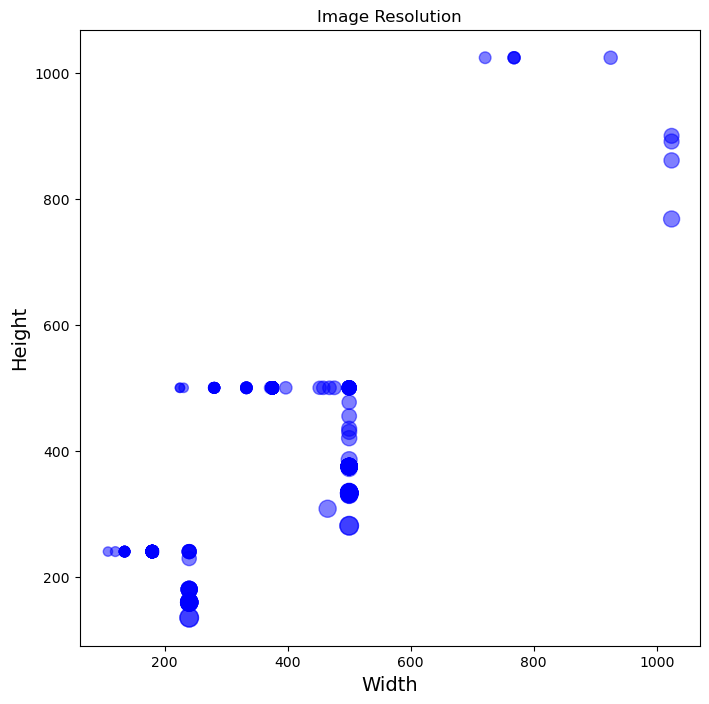

In [13]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [17]:
def rescale_image(id_name, img_name):
    image  = Image.open(f"../raws/{id_name}/{img_name}")
    width  = image.size[0]
    height = image.size[1]

    aspect = width / float(height)

    ideal_width = 500
    ideal_height = 500

    ideal_aspect = ideal_width / float(ideal_height)

    if aspect > ideal_aspect:
        # Then crop the left and right edges:
        new_width = int(ideal_aspect * height)
        offset = (width - new_width) / 2
        resize = (offset, 0, width - offset, height)
    else:
        # ... crop the top and bottom:
        new_height = int(width / ideal_aspect)
        offset = (height - new_height) / 2
        resize = (0, offset, width, height - offset)

    thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)
    thumb.save(f"../rescaled/{id_name}/{img_name}")


In [18]:
print(os.getcwd())

for ind in img_meta_df.index:
    rescale_image(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_22040\3970279637.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)


Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Finished Index: 49
Finished Index: 50
Finished Index: 51
Finished Index: 52
Finished Index: 53
Finished Index: 54
Finished Index: 55
Finished Index: 56
Finished Index: 57
Finished Index: 

# Preparation for Preprocessing

In [19]:
# Create directories for preprocessed images

owd = os.getcwd()
print(owd)
os.chdir('../clean')
print("Switching Directory ...")
print(os.getcwd())

new_directories_list = ["rawsRGB_to_Grayscale", "Grayscale_to_Binary", "Binary_to_Smoothing", "Smoothing_to_Filtering"]

for directory in new_directories_list:
    try:
        os.mkdir(str(directory))
    except:
        print("[Outer] Count not create outer directory!")

for directory in new_directories_list:
    for inner_directory in dir_list:
        try:
            print("Switching Directory ...")
            os.chdir(directory)
            print(os.getcwd())
        except:
            print("Unable to switch Diretory!")

        try:
            os.mkdir(str(inner_directory))
            print("Switching Directory ...")
            os.chdir("../")
            print(os.getcwd())
        except:
            print("[Inner] Count not create inner directory!")
    os.chdir("../")


# Back to original directory for rerunning
os.chdir('../leaf_recognition_system')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Switching Directory ...
d:\University\4-2\Thesis\Plantaea_Image_Processing\clean
[Outer] Count not create outer directory!
[Outer] Count not create outer directory!
[Outer] Count not create outer directory!
[Outer] Count not create outer directory!
Switching Directory ...
d:\University\4-2\Thesis\Plantaea_Image_Processing\clean\rawsRGB_to_Grayscale
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directory ...
d:\University\4-2\Thesis\Plantaea_Image_Processing\clean\Grayscale_to_Binary
[Inner] Count not create inner directory!
Switching Directory ...
Unable to switch Diretory!
[Inner] Count not create inner directory!
Switching Directo

# Preprocessing

In [9]:
# Import csv
img_meta_df = pd.read_csv("../csv/inaturalist_imgs_metadata.csv", index_col = 0)
img_meta_df

,plant_id,FileName,Size,Width,Height,Aspect Ratio
0,Blumea_balsamifera,large--4xtMuA.jpg,"(1024, 900)",1024,900,1.14
1,Blumea_balsamifera,large--GzNRNS.jpg,"(1024, 768)",1024,768,1.33
2,Blumea_balsamifera,large--J3Qpq8.jpg,"(1024, 891)",1024,891,1.15
3,Blumea_balsamifera,large--K1b36l.jpg,"(768, 1024)",768,1024,0.75
4,Blumea_balsamifera,large--Td4LvB.jpg,"(721, 1024)",721,1024,0.70
...,...,...,...,...,...,...
351,Vitex_nagundo,small--X8hjBO.jpg,"(180, 240)",180,240,0.75
352,Vitex_nagundo,small--xApS2H.jpeg,"(240, 159)",240,159,1.51
353,Vitex_nagundo,small--YeUNjz.jpg,"(180, 240)",180,240,0.75
354,Vitex_nagundo,small-s9aq99a.jpeg,"(240, 159)",240,159,1.51


In [21]:
# RGB to Grayscale

def image_to_grayscale(id_name, img_name):
    image = cv2.imread(f"../rescaled/{id_name}/{img_name}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    path = '../clean/rawsRGB_to_Grayscale/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), gray, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [22]:
print(os.getcwd())

for ind in img_meta_df.index:
    image_to_grayscale(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [1]:
# Grayscale to Binary

def grayscale_to_binary(id_name, img_name):
    image = cv2.imread(f"../clean/rawsRGB_to_Grayscale/{id_name}/{img_name}")
    ret,thresh = cv2.threshold(image, 70, 255, 0)

    path = '../clean/Grayscale_to_Binary/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), thresh, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [27]:
print(os.getcwd())

for ind in img_meta_df.index:
    grayscale_to_binary(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [11]:
# https://stackoverflow.com/questions/62078016/smooth-the-edges-of-binary-images-face-using-python-and-open-cv

def binary_to_smoothing(id_name, img_name):
    # load image
    img = cv2.imread(f'../clean/Grayscale_to_Binary/{id_name}/{img_name}')
    
    # blur threshold image
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
    
    # stretch so that 255 -> 255 and 127.5 -> 0
    # C = A*X+B
    # 255 = A*255+B
    # 0 = A*127.5+B
    # Thus A=2 and B=-127.5
    #aa = a*2.0-255.0 does not work correctly, so use skimage
    result = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))
    
    # save output
    path = '../clean/Binary_to_Smoothing/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), result)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
print(os.getcwd())

for ind in img_meta_df.index:
    binary_to_smoothing(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini

In [13]:
# Grayscale to Binary

def smoothing_to_filtering(id_name, img_name):
    ## edge detection
    park = cv2.imread(f'../clean/Binary_to_Smoothing/{id_name}/{img_name}')
    park = cv2.cvtColor(park, cv2.COLOR_BGR2RGB)
    edge = cv2.Canny(park, 100, 200)

    path = '../clean/Smoothing_to_Filtering/'
    cv2.imwrite(os.path.join(path , '{0}/{1}'.format(id_name, img_name)), edge, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [14]:
print(os.getcwd())

for ind in img_meta_df.index:
    smoothing_to_filtering(img_meta_df['plant_id'][ind], img_meta_df['FileName'][ind])
    print(f'Finished Index: {ind}')

d:\University\4-2\Thesis\Plantaea_Image_Processing\leaf_recognition_system
Finished Index: 0
Finished Index: 1
Finished Index: 2
Finished Index: 3
Finished Index: 4
Finished Index: 5
Finished Index: 6
Finished Index: 7
Finished Index: 8
Finished Index: 9
Finished Index: 10
Finished Index: 11
Finished Index: 12
Finished Index: 13
Finished Index: 14
Finished Index: 15
Finished Index: 16
Finished Index: 17
Finished Index: 18
Finished Index: 19
Finished Index: 20
Finished Index: 21
Finished Index: 22
Finished Index: 23
Finished Index: 24
Finished Index: 25
Finished Index: 26
Finished Index: 27
Finished Index: 28
Finished Index: 29
Finished Index: 30
Finished Index: 31
Finished Index: 32
Finished Index: 33
Finished Index: 34
Finished Index: 35
Finished Index: 36
Finished Index: 37
Finished Index: 38
Finished Index: 39
Finished Index: 40
Finished Index: 41
Finished Index: 42
Finished Index: 43
Finished Index: 44
Finished Index: 45
Finished Index: 46
Finished Index: 47
Finished Index: 48
Fini